<a href="https://colab.research.google.com/github/ernesto-miguez/UOC/blob/main/Data_partitioning_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## 1. Temporal partitioning

In [28]:
trn_crd = pd.read_csv('LWAT01_trncrd.csv', header=None, usecols=[0, 1])
trn_crd.head()

,0,1
0,0.076851,0.894201
1,0.076847,0.894169
2,0.076953,0.894230
3,0.076847,0.894158
4,0.076983,0.894148


In [29]:
trn_rss = pd.read_csv('LWAT01_trnrss.csv', header=None)
trn_rss.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-200,-200,-200,-200,-99,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-200,-200,-200,-200,-95,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-200,-200,-200,-200,-107,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-90,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-200,-200,-103,-98,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


In [30]:
tst_crd = pd.read_csv('LWAT01_tstcrd.csv', header=None, usecols=[0, 1])
tst_crd.head()

,0,1
0,0.076948,0.894150
1,0.076856,0.894155
2,0.076833,0.894133
3,0.076775,0.894027
4,0.076723,0.893950


In [31]:
tst_rss = pd.read_csv('LWAT01_tstrss.csv', header=None)
tst_rss.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-200,-200,-200,-115,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-200,-200,-200,-200,-91,-109,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-200,-200,-200,-200,-96,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-100,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-200,-200,-200,-109,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


### 1.1 EDA

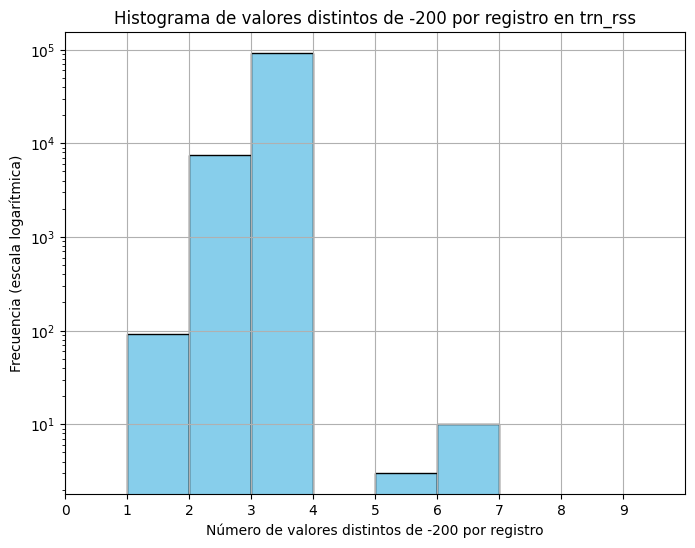

In [ ]:
# Calcular la cantidad de valores distintos de -200 por registro
num_valid_values_per_record = np.sum(trn_rss != -200, axis=1)

# Crear el histograma con escala logarítmica en el eje y
plt.figure(figsize=(8, 6))
plt.hist(num_valid_values_per_record, bins=np.arange(0, trn_rss.shape[1]+1), color='skyblue', edgecolor='black', log=True)
plt.xlabel('Número de valores distintos de -200 por registro')
plt.ylabel('Frecuencia (escala logarítmica)')
plt.title('Histograma de valores distintos de -200 por registro en trn_rss')
plt.xlim(0, 10)
plt.xticks(np.arange(10))
plt.grid(True)
plt.show()

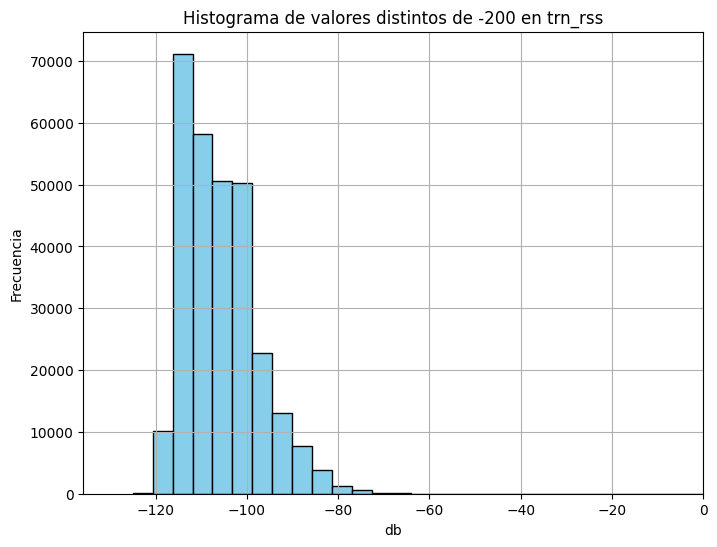

In [ ]:
# Obtener los valores distintos de -200 en trn_rss
values = trn_rss.values.flatten()
values = values[values != -200]

# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('db')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores distintos de -200 en trn_rss')
plt.xlim(right=0)
plt.grid(True)
plt.show()

In [ ]:
file = pd.read_csv('lorawan_antwerp_2019_dataset.csv') # doi 10.5281/zenodo.1212478
file.head()

<ipython-input-2-8c21e0f091f8>:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv('lorawan_antwerp_2019_dataset.csv') # doi 10.5281/zenodo.1212478


,BS 1,BS 2,BS 3,BS 4,BS 5,BS 6,BS 7,BS 8,BS 9,BS 10,...,BS 68,BS 69,BS 70,BS 71,BS 72,RX Time,SF,HDOP,Latitude,Longitude
0,-200,-200,-200,-117,-114,-200,-119,-200,-112,-200,...,-200.0,-200.0,-200.0,-200.0,-200.0,2019-01-11T11:27:31.534+01:00,8.0,0.75,51.233997,4.426105
1,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200.0,-115.0,-200.0,-200.0,-200.0,2019-01-15T09:55:04.560+01:00,7.0,0.64,51.207180,4.403681
2,-200,-100,-200,-200,-200,-200,-200,-200,-200,-119,...,-200.0,-200.0,-200.0,-200.0,-200.0,2019-01-03T12:06:00.983+01:00,11.0,0.84,51.200180,4.414371
3,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200.0,-200.0,-200.0,-200.0,-200.0,2019-01-23T08:13:58.520215889+01:00,7.0,0.62,51.204826,4.390655
4,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200.0,-200.0,-200.0,-200.0,-200.0,2019-01-29T17:20:20.826210335+01:00,7.0,0.66,51.215767,4.410506


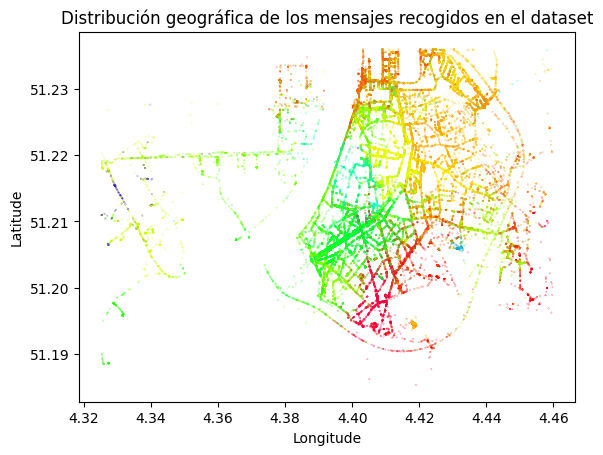

In [ ]:
file = pd.read_csv('lorawan_antwerp_2019_dataset.csv') # doi 10.5281/zenodo.1212478
columns = file.columns
x = file[columns[0:72]]
x = -abs(x)
y = file[columns[75:]]
y_values = y.values

# clustering per closest gateway
m = pd.DataFrame.idxmax(x,axis=1)
i = 1
indexing = dict()
for col in columns:
    indexing[col] = i
    i = i+1
colors = list()
for entry in m:
    colors.append(indexing[entry])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribución geográfica de los mensajes recogidos en el dataset')
plt.scatter(y_values[:,1],y_values[:,0],c=colors,s=0.1, marker='.',cmap='hsv')
plt.show()

### 1.2 KNN-based fingerprinting

In [6]:
# Función para calcular la distancia euclidiana entre dos puntos
def haversine(coord1, coord2):
    # Radio de la Tierra en metros
    R = 6371000

    lon1, lat1 = coord1
    lon2, lat2 = coord2

    # Diferencia de coordenadas
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Calcular la distancia usando la fórmula del haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c

    return distance

In [ ]:
# Crear el modelo k-NN
def knn_fingerprinting(k):
  knn_model = KNeighborsRegressor(n_neighbors=k)
  knn_model.fit(trn_rss, trn_crd)

  # Predecir los RSSI para los datos de prueba
  predicted_crd = knn_model.predict(tst_rss)

  # Convertimos a array
  tst_crd_array = np.array(tst_crd)

  # Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
  distances = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

  # Calcular el error medio
  mean_error = np.mean(distances)

  return "Error medio: " + str(np.round(mean_error, 2)) + " m"

In [ ]:
knn_fingerprinting(k=3)

'Error medio: 504.44 m'

In [ ]:
knn_fingerprinting(k=12)

'Error medio: 475.8 m'

### 1.3 DL-based fingerprinting

1.3.1 FCN

In [ ]:
# Definir la arquitectura de la red neuronal
class FingerprintingNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)  # Salida de 2 dimensiones para las coordenadas (longitud, latitud)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = R * c

        return torch.mean(distance)

# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo
input_size = trn_rss.shape[1]
hidden_size = 100
model = FingerprintingNN(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
#criterion = nn.MSELoss()
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass y cálculo de la pérdida
    outputs = model(trn_rss_tensor)
    loss = criterion(outputs, trn_crd_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

Epoch [10/100], Loss: 4004173.5000
Epoch [20/100], Loss: 2192148.0000
Epoch [30/100], Loss: 1155737.2500
Epoch [40/100], Loss: 695039.8125
Epoch [50/100], Loss: 546039.0625
Epoch [60/100], Loss: 417940.4062
Epoch [70/100], Loss: 353695.8125
Epoch [80/100], Loss: 302059.3750
Epoch [90/100], Loss: 262494.5000
Epoch [100/100], Loss: 231121.6406
Error medio (distancia haversine): 272504.47 m


1.3.2 LSTM 1 (1 layer, 64 neurons, sigmoid, dropout=0.1, loss=mse)

In [ ]:
# Definir la arquitectura de la red neuronal

class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo
input_size = trn_rss.shape[1]
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de pérdida para calcular distancia en datos predichos
criterion2 = HaversineLoss()

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass y cálculo de la pérdida
    outputs = model(trn_rss_tensor)
    loss = criterion(outputs, trn_crd_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion2(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

Epoch [10/100], Loss: 0.1482
Epoch [20/100], Loss: 0.0986
Epoch [30/100], Loss: 0.0081
Epoch [40/100], Loss: 0.0022
Epoch [50/100], Loss: 0.0024
Epoch [60/100], Loss: 0.0015
Epoch [70/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0003
Error medio (distancia haversine): 122392.35 m


LSTM 2 (1 layer, 64 neurons, sigmoid, dropout=0.1, batch_size=512, loss=haversine loss)

Epoch [1/100], Training Loss: 551246.4920, Validation Loss: 23304.7793
Epoch [2/100], Training Loss: 87871.1247, Validation Loss: 13260.6865
Epoch [3/100], Training Loss: 74471.2362, Validation Loss: 10840.9863
Epoch [4/100], Training Loss: 67455.8311, Validation Loss: 12635.3682
Epoch [5/100], Training Loss: 63690.2691, Validation Loss: 9133.4111
Epoch [6/100], Training Loss: 60418.0355, Validation Loss: 11777.4590
Epoch [7/100], Training Loss: 58147.8505, Validation Loss: 12485.7734
Epoch [8/100], Training Loss: 55935.1529, Validation Loss: 10323.9209
Epoch [9/100], Training Loss: 54598.4340, Validation Loss: 6576.0044
Epoch [10/100], Training Loss: 52871.8385, Validation Loss: 8013.2769
Epoch [11/100], Training Loss: 51242.1785, Validation Loss: 9762.5703
Epoch [12/100], Training Loss: 50123.1018, Validation Loss: 8783.6016
Epoch [13/100], Training Loss: 48698.7701, Validation Loss: 7649.4087
Epoch [14/100], Training Loss: 47070.6244, Validation Loss: 7735.6001
Epoch [15/100], Train

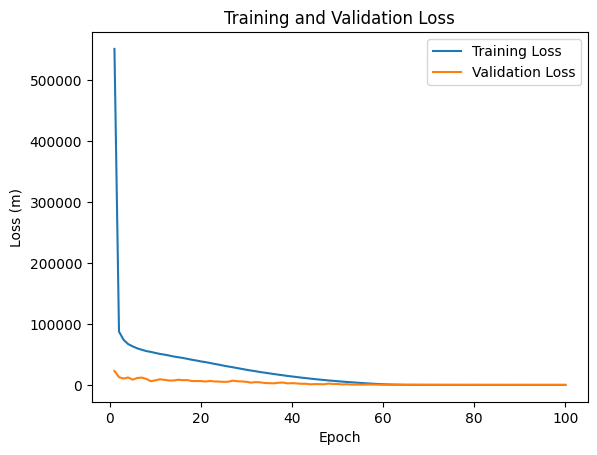

Error medio (distancia haversine): 540.9 m


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

LSTM 3 (2 layers, 64 neurons, sigmoid, batch_size=512, loss=haversine loss)

Epoch [1/100], Training Loss: 300662.8490, Validation Loss: 7068.3335
Epoch [2/100], Training Loss: 16354.3673, Validation Loss: 5987.9854
Epoch [3/100], Training Loss: 12842.9534, Validation Loss: 2666.2480
Epoch [4/100], Training Loss: 11329.6335, Validation Loss: 5067.8286
Epoch [5/100], Training Loss: 10391.4624, Validation Loss: 4356.8140
Epoch [6/100], Training Loss: 10759.9527, Validation Loss: 3611.0139
Epoch [7/100], Training Loss: 8183.6029, Validation Loss: 8130.4443
Epoch [8/100], Training Loss: 6005.7218, Validation Loss: 10195.5498
Epoch [9/100], Training Loss: 7328.3494, Validation Loss: 5373.0200
Epoch [10/100], Training Loss: 6453.3980, Validation Loss: 5847.7856
Epoch [11/100], Training Loss: 5972.5826, Validation Loss: 5431.8120
Epoch [12/100], Training Loss: 5544.1624, Validation Loss: 5469.4878
Epoch [13/100], Training Loss: 5138.8043, Validation Loss: 4266.2725
Epoch [14/100], Training Loss: 4953.4850, Validation Loss: 6135.7900
Epoch [15/100], Training Loss: 4887

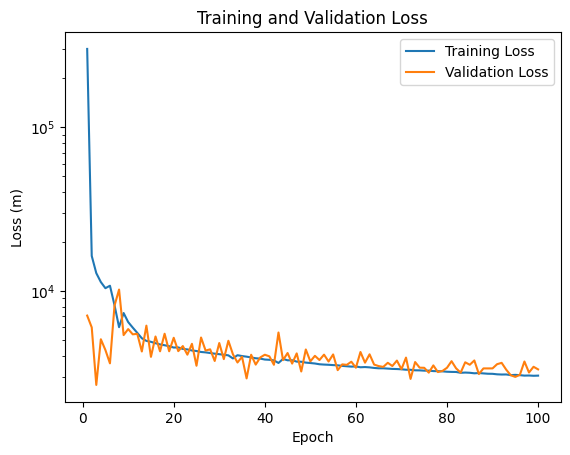

Error medio (distancia haversine): 3317.9 m


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.yscale('log')  # Cambiar la escala a logarítmica
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

LSTM 3 (2 layers, 64 neurons, sigmoid, dropout=0.3, batch_size=512, loss=haversine loss)

Epoch [1/100], Training Loss: 331607.7900, Validation Loss: 8527.8066
Epoch [2/100], Training Loss: 18178.1310, Validation Loss: 7161.7466
Epoch [3/100], Training Loss: 15110.9515, Validation Loss: 9108.3613
Epoch [4/100], Training Loss: 15550.9819, Validation Loss: 13965.8975
Epoch [5/100], Training Loss: 13702.2347, Validation Loss: 7431.3853
Epoch [6/100], Training Loss: 10283.8422, Validation Loss: 5506.4775
Epoch [7/100], Training Loss: 9255.5578, Validation Loss: 7684.6992
Epoch [8/100], Training Loss: 6564.8677, Validation Loss: 3207.0918
Epoch [9/100], Training Loss: 7487.0247, Validation Loss: 5759.2598
Epoch [10/100], Training Loss: 7432.9397, Validation Loss: 7676.9209
Epoch [11/100], Training Loss: 6924.3525, Validation Loss: 5477.0791
Epoch [12/100], Training Loss: 6245.5726, Validation Loss: 6669.1860
Epoch [13/100], Training Loss: 6177.5479, Validation Loss: 6460.1626
Epoch [14/100], Training Loss: 5788.1205, Validation Loss: 5250.6406
Epoch [15/100], Training Loss: 5511

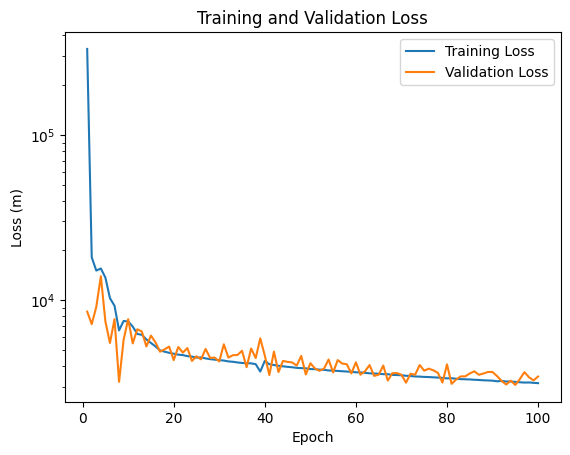

Error medio (distancia haversine): 3452.89 m


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.yscale('log')  # Cambiar la escala a logarítmica
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

LSTM 4 (1 layer, 64 neurons, sigmoid, dropout=0.3, batch_size=512, loss=haversine loss)

Epoch [1/100], Training Loss: 473629.6339, Validation Loss: 33200.0664
Epoch [2/100], Training Loss: 122972.0582, Validation Loss: 18518.9492
Epoch [3/100], Training Loss: 108470.2542, Validation Loss: 14694.1758
Epoch [4/100], Training Loss: 100063.3751, Validation Loss: 16235.2383
Epoch [5/100], Training Loss: 95463.1020, Validation Loss: 12548.5859
Epoch [6/100], Training Loss: 92205.9395, Validation Loss: 10163.8018
Epoch [7/100], Training Loss: 88240.8054, Validation Loss: 9534.6445
Epoch [8/100], Training Loss: 84808.7785, Validation Loss: 12318.4521
Epoch [9/100], Training Loss: 81830.4326, Validation Loss: 10719.3818
Epoch [10/100], Training Loss: 78462.3756, Validation Loss: 7419.7231
Epoch [11/100], Training Loss: 75016.0192, Validation Loss: 9242.0322
Epoch [12/100], Training Loss: 71088.4889, Validation Loss: 8070.0156
Epoch [13/100], Training Loss: 67903.1208, Validation Loss: 7935.7227
Epoch [14/100], Training Loss: 64222.1170, Validation Loss: 7721.7256
Epoch [15/100], T

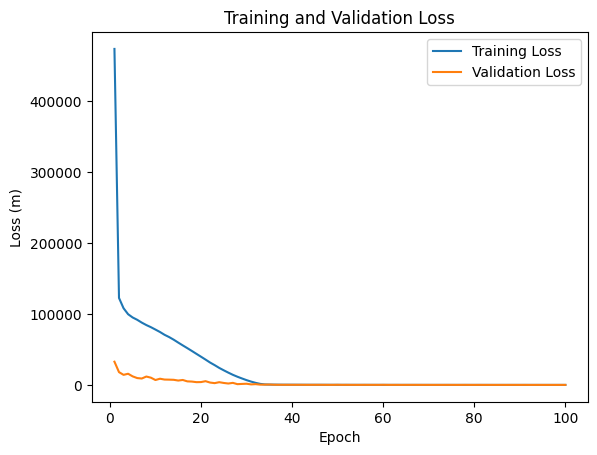

Error medio (distancia haversine): 559.21 m


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

LSTM 5 (2 layers, 64 neurons, sigmoid, dropout=0.1, batch_size=512, loss=haversine loss)

Epoch [1/100], Training Loss: 337900.1799, Validation Loss: 7627.3218
Epoch [2/100], Training Loss: 16951.8284, Validation Loss: 6377.6001
Epoch [3/100], Training Loss: 13465.3673, Validation Loss: 3582.2954
Epoch [4/100], Training Loss: 10645.2339, Validation Loss: 7566.0659
Epoch [5/100], Training Loss: 10547.0502, Validation Loss: 4333.3608
Epoch [6/100], Training Loss: 9354.8755, Validation Loss: 8513.6270
Epoch [7/100], Training Loss: 12736.5256, Validation Loss: 9398.2744
Epoch [8/100], Training Loss: 9767.6070, Validation Loss: 4537.1226
Epoch [9/100], Training Loss: 7353.0906, Validation Loss: 5844.5503
Epoch [10/100], Training Loss: 6906.4872, Validation Loss: 5767.0127
Epoch [11/100], Training Loss: 6628.2845, Validation Loss: 5993.2715
Epoch [12/100], Training Loss: 6351.0112, Validation Loss: 3875.8000
Epoch [13/100], Training Loss: 5882.9344, Validation Loss: 3339.6868
Epoch [14/100], Training Loss: 5701.7238, Validation Loss: 5070.7603
Epoch [15/100], Training Loss: 5444.

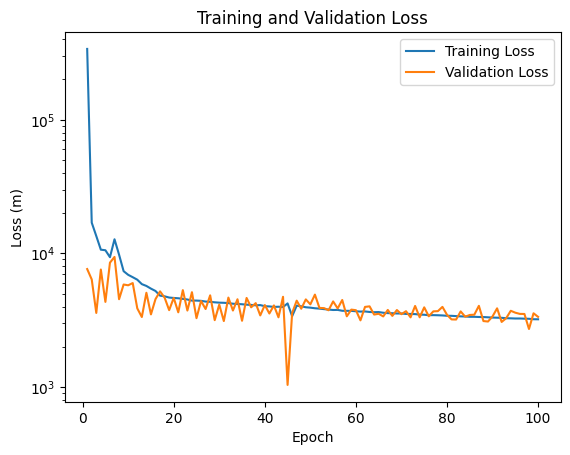

Error medio (distancia haversine): 3348.52 m


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.yscale('log')  # Cambiar la escala a logarítmica
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

Arquitectura MLP Anagnostopoulos

In [ ]:
dropout = 0.15
lr = 0.0005
epochs = 10000
batch_size= 512
patience = 300

# Definir la arquitectura del modelo en PyTorch
class FingerprintingModel(nn.Module):
    def __init__(self, input_size):
        super(FingerprintingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc6 = nn.Linear(128, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.fc7 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.activation(self.bn1(self.fc1(x))))
        x = self.dropout(self.activation(self.bn2(self.fc2(x))))
        x = self.dropout(self.activation(self.bn3(self.fc3(x))))
        x = self.dropout(self.activation(self.bn4(self.fc4(x))))
        x = self.dropout(self.activation(self.bn5(self.fc5(x))))
        x = self.dropout(self.activation(self.bn6(self.fc6(x))))
        x = self.fc7(x)
        return x


# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = R * c

        return torch.mean(distance)


# Convertir los datos a tensores de PyTorch
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo
input_size = trn_rss.shape[1]
model = FingerprintingModel(input_size)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # Mean Absolute Error

# Definir la función de pérdida para calcular distancia en datos predichos
criterion2 = HaversineLoss()

# Entrenar el modelo
train_losses = []
val_losses = []
best_val_loss = float('inf')
early_stop_counter = 0
for epoch in range(epochs):
    # Modo de entrenamiento
    model.train()

    # Forward pass
    outputs = model(trn_rss_tensor)
    loss = criterion(outputs, trn_crd_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Modo de evaluación
    model.eval()
    with torch.no_grad():
        val_outputs = model(tst_rss_tensor)
        val_loss = criterion(val_outputs, tst_crd_tensor)
        val_losses.append(val_loss.item())

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter > patience:
            print(f'Early stopping at epoch {epoch}')
            break

# Graficar los resultados
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    predicted_crd_tensor = model(tst_rss_tensor)


# Calcular el error medio
mean_error = criterion2(predicted_crd_tensor, tst_crd_tensor).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

XGBoost

In [43]:
# Convertir todas las columnas a tipo numérico
trn_rss_num = trn_rss.apply(pd.to_numeric, errors='coerce')
trn_crd_num = trn_crd.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
trn_rss_num.dropna(inplace=True)
trn_crd_num.dropna(inplace=True)

# Convertir a array
tst_crd_array = tst_crd.values

# Entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(trn_rss_num, trn_crd_num)

# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c

        return np.mean(distance)

# Realizar predicciones en el conjunto de prueba
predicted_crd = model.predict(tst_rss)

# Calcular el error medio
criterion2 = HaversineLoss()
mean_error = criterion2(predicted_crd, tst_crd_array).item()

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )

Error medio (distancia haversine): 600.66 m


## 2. Random partitioning

In [ ]:
# Se ejecuta el script 'LoRaWAN_random_split.py' para generar ficheros particionados aleatoriamente que se cargan a continuación
train_rss_random = pd.read_csv('train_rss_random.csv')
train_crd_random = pd.read_csv('train_crd_random.csv')
val_rss_random = pd.read_csv('val_rss_random.csv')
val_crd_random = pd.read_csv('val_crd_random.csv')

In [ ]:
train_rss_random.head()

,BS 1,BS 2,BS 3,BS 4,BS 5,BS 6,BS 7,BS 8,BS 9,BS 10,...,BS 59,BS 60,BS 61,BS 62,BS 63,BS 64,BS 65,BS 66,BS 67,BS 68
0,-103,-103,-200,-200,-200,-200,-200,-200,-200,-79,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-111,-92,-85,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-117,-200,-200,-200,-200,-200,-120,-109,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-98,-200,-200,-200,-200,-108,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


In [ ]:
train_crd_random.head()

,Longitude,Latitude
0,0.077119,0.893511
1,0.077238,0.893668
2,0.077709,0.893796
3,0.076969,0.893717
4,0.077164,0.893656


In [ ]:
val_rss_random.head()

,BS 1,BS 2,BS 3,BS 4,BS 5,BS 6,BS 7,BS 8,BS 9,BS 10,...,BS 59,BS 60,BS 61,BS 62,BS 63,BS 64,BS 65,BS 66,BS 67,BS 68
0,-200,-93,-105,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
1,-200,-200,-200,-112,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
2,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
3,-200,-200,-200,-200,-104,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200
4,-200,-200,-200,-200,-200,-200,-200,-200,-99,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200


In [ ]:
val_crd_random.head()

,Longitude,Latitude
0,0.077189,0.893774
1,0.076781,0.894037
2,0.076878,0.894083
3,0.077135,0.894164
4,0.077427,0.894000


### 2.1 KNN-based fingerprinting (K=3)

In [ ]:
# Crear el modelo k-NN
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(train_rss_random, train_crd_random)

# Predecir los RSSI para los datos de prueba
predicted_crd_random = knn_model.predict(val_rss_random)

# Convertimos a array
val_crd_array_random = np.array(val_crd_random)

# Calcular la distancia euclidiana entre las coordenadas predichas y las coordenadas reales
distances_random = [haversine(pred, real) for pred, real in zip(predicted_crd_random, val_crd_array_random)]

# Calcular el error medio
mean_error_random = np.mean(distances_random)

# Imprimir el error medio
print("Error medio:", mean_error_random)

Error medio: 420.66445099883015
